# Import API

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import io,image
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.19.0


# Build Model

In [5]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

# Split the data(ONLY RUN ONCE)

In [14]:
Path = '/Volumes/Datasets/alligator vs crocodile'

In [16]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Original dataset path
original_path = Path
# Destination split dataset path
split_path = '/Volumes/Datasets/split_data'

# Define class names (folder names)
classes = ['alligator', 'crocodile']

# Split ratio
test_size = 0.2  # 80% train, 20% test

# Loop through each class
for class_name in classes:
    class_dir = os.path.join(original_path, class_name)
    images = os.listdir(class_dir)
    images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Split the files
    train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)

    for split, split_imgs in zip(['train', 'test'], [train_imgs, test_imgs]):
        split_class_dir = os.path.join(split_path, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img_name in split_imgs:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_class_dir, img_name)
            shutil.copyfile(src, dst)

print("Dataset successfully split into train/test.")


KeyboardInterrupt: 

# Preprocess The Data

In [26]:
# Paths to training and testing directories
train_dir = '/Volumes/Datasets/alligator vs crocodile/split_data/train'
test_dir = '/Volumes/Datasets/alligator vs crocodile/split_data/test'

In [28]:
# Image data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)  

In [30]:
# Load and preprocess the entire dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='binary',
    classes=['crocodile', 'alligator']  # optional if alphabetically sorted
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='binary',
    classes=['crocodile', 'alligator']
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='binary',
    classes=['crocodile', 'alligator']
)

Found 2956 images belonging to 2 classes.
Found 740 images belonging to 2 classes.
Found 740 images belonging to 2 classes.


In [32]:
print(train_generator.class_indices)  # {'alligator': 0, 'crocodile': 1}


{'crocodile': 0, 'alligator': 1}


In [34]:
print(test_generator.class_indices)

{'crocodile': 0, 'alligator': 1}


# Train the Model

In [36]:
es = EarlyStopping(monitor='val_accuracy', patience=5)
mcp = ModelCheckpoint('Models/Best2.keras', save_best_only=True)

In [38]:
# Fit the model to the training data
history = model.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=[es,mcp])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - accuracy: 0.5065 - loss: 0.7566 - val_accuracy: 0.4676 - val_loss: 0.6959
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.5249 - loss: 0.6937 - val_accuracy: 0.4635 - val_loss: 0.6948
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.5326 - loss: 0.6923 - val_accuracy: 0.4581 - val_loss: 0.6992
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.5584 - loss: 0.6858 - val_accuracy: 0.5324 - val_loss: 0.6928
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.5663 - loss: 0.6857 - val_accuracy: 0.5459 - val_loss: 0.6910
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.5664 - loss: 0.6808 - val_accuracy: 0.5405 - val_loss: 0.6897
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.5941 - loss: 0.6758 - val_accuracy: 0.5405 - val_loss: 0.6904
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.5844 - loss: 0.6755 - val_accuracy: 0.5676 - v

In [100]:
# Save the trained model
model.save('Models/alligator_crocodile_classifier86.keras')

In [6]:
#load/import model
new_model = load_model('Models/alligator_crocodile_classifier86.keras')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Prediction

In [10]:
Path = '/Volumes/Datasets/alligator vs crocodile'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
The model predicts that the image contains a alligator.


/var/folders/p8/5y8nk565329f4nf8lyxjhv1w0000gn/T/ipykernel_21969/4179183908.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(np.round(prediction))]


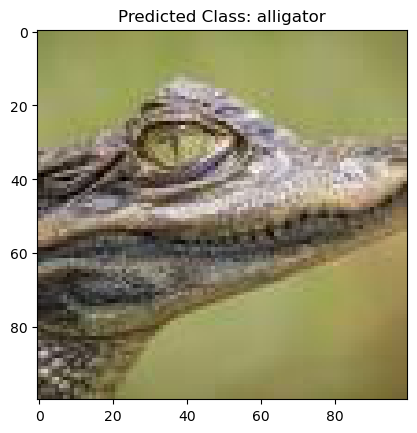

In [28]:
# Function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the new image you want to predict
new_image_path = Path + '/crocodile/crocodile7.jpeg'  # Replace with the path to your new image file

# Preprocess the new image
preprocessed_image = preprocess_image(new_image_path)

# Make a prediction
prediction = new_model.predict(preprocessed_image)

# Class labels
class_labels = ['crocodile', 'alligator']

# Print the prediction result
predicted_class = class_labels[int(np.round(prediction))]
print(f"The model predicts that the image contains a {predicted_class}.")

# Display the image
img = image.load_img(new_image_path)
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class}")
plt.show()


# Metrics

## Identify better threshold

ROC = Receiver Operating Characteristic Curve
It plots:

True Positive Rate (Recall) on Y-axis
False Positive Rate (1 - Specificity) on X-axis
As you sweep the threshold from 0 → 1.

This helps you choose an optimal threshold instead of defaulting to 0.5.

12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


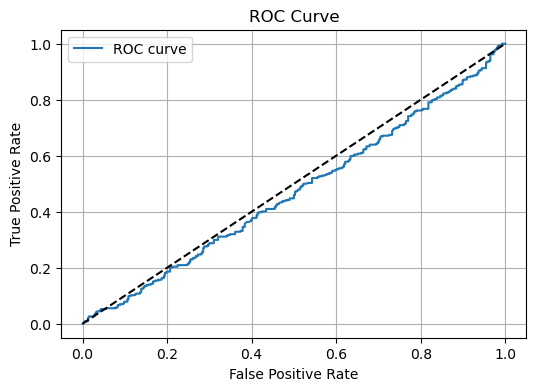

AUC Score: 0.4705


In [159]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities
y_probs = model.predict(test_generator, verbose=1).ravel()  # flatten shape

# Get true labels
y_true = test_generator.classes

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0,1], [0,1], 'k--')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Compute AUC
auc = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc:.4f}")


In [161]:
# Youden’s J statistic to find the optimal threshold
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print(f"Best Threshold: {best_threshold:.3f}")

Best Threshold: 1.000


## Confusion Matrix

12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


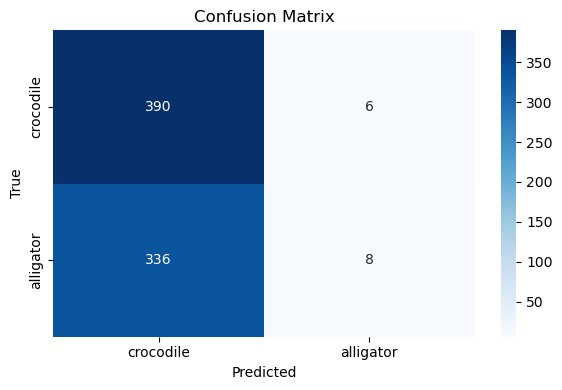

              precision    recall  f1-score   support

   crocodile       0.54      0.98      0.70       396
   alligator       0.57      0.02      0.04       344

    accuracy                           0.54       740
   macro avg       0.55      0.50      0.37       740
weighted avg       0.55      0.54      0.39       740



In [165]:


# Step 1: Get predictions from your trained model
Y_pred_probs = model.predict(test_generator, verbose=1)
Y_pred = (Y_pred_probs > best_threshold).astype(int).ravel()  # Used Best Threshold

# Step 2: Get true labels from the generator
Y_true = test_generator.classes

# Step 3: Generate confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Step 4: Plot the confusion matrix
labels = list(test_generator.class_indices.keys())  # ['alligator', 'crocodile'] if sorted

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Optional: Detailed report
print(classification_report(Y_true, Y_pred, target_names=labels))
